# Analytical solution: Normal-Normal model with known precision

In [1]:
from scipy.stats import norm
import numpy as np
import seaborn as sns; sns.set_context('notebook');
import matplotlib.pyplot as plt

%matplotlib inline

In the last notebook we have solved the Beta-Binomial model analytically and found that a Binomial likelihood is conjugate with a Beta prior.  This means that the posterior distribution is also a Beta distribution but with updated parameters.

In this case, we assume that we are interested in estimating some parameter $\mu$ that we cannot observe directly but we can measure some estimate $X$ using a measurement device with a known and fixed variance (or precision, defined below) and that the measurement error is normally distributed.  We further assume that our prior on the value of the parameter is also normal with an assumed mean and precision.

Using our assumptions and this one measurement, we want to obtain an estimate of $\mu$.

## Parametrizing a Normal distribution
A Normal distribution can be parametrized by a mean $\mu$ and variance $\sigma^2$ but alternatively (and less frequently) it can be parametrized by a mean $
\mu$ and precision $\tau = \sigma^{-2}$.

Thus, instead of denoting $X \sim {\cal N}(\mu,\sigma^2)$, we write $X \sim {\cal N}(\mu,\tau)$.

## Formalizing the problem

We are interested in estimating $\mu$ given our prior assumptions and given the one observation $X$.  Note: we use the function $f$ to denote all densities which are distinguished according to their parameters.

By assumption, we have

$$f(\mu) \sim {\cal N}(\mu_0, \tau_0),$$

for some apriori chosen (assumed) $\mu, \tau_0$.  We also assume that the observation $X$ is distributed as

$$f(X|\mu) \sim {\cal N}(\mu, \tau),$$

where again we assume that we know the precision $\tau$ because the manufacturer states it (or the standard deviation) on the device.

The question now is, what is the distribution of $\mu|x$ given a measurement $x$.  By the Bayes theorem, we know that

$$f(\mu|X) \propto f(X|\mu)f(\mu).$$

The only parameter we are interested in is $\mu$, so any multiplicative terms that don't contain $\mu$ can be neglected in the following calculations, since the equation above requires that we preserve proportionality, not equality.  This is very important to remember as otherwise the proceedings can become very difficult in more complicated models.

For example, although the full density of $f(\mu)$ is

$$f(\mu) = \sqrt{\frac{\tau_0}{2\pi}} \exp \left ( -\frac{\tau_0}{2}(\mu-\mu_0)^2 \right ),$$

we can simplify this form by removing all apparent constant factors and writing

$$f(\mu) \propto \exp \left ( -\frac{\tau_0}{2}(\mu-\mu_0)^2 \right ),$$

since even $\tau_0$ is assumed constant.

In a similar vein, we can write

$$f(X|\mu) \propto \exp \left ( -\frac{\tau}{2}(X-\mu)^2 \right ),$$

which is also considerably simpler.

## Formal solution

We can then write that

$$f(\mu|X) \propto f(X|\mu)f(\mu) \propto \exp \left ( -\frac{\tau}{2}(X-\mu)^2 \right ) \exp \left ( -\frac{\tau_0}{2}(\mu-\mu_0)^2 \right ).$$

The only thing left to do is to determine what form is this distribution. This is again a normal distribution but we must determine its mean value and precision given assumptions and measurements.

After merging both exponential terms, we only have one expression containing terms with $\mu^2$,$\mu$ and terms without $\mu$:

$$\exp \left ( -\frac{\tau}{2}(X-\mu)^2 \right ) \exp \left ( -\frac{\tau_0}{2}(\mu-\mu_0)^2 \right ) = \exp \left ( -\frac{\tau}{2}(X-\mu)^2 -\frac{\tau_0}{2}(\mu-\mu_0)^2 \right ).$$

This looks like the result could again be a normal distribution.  This leads us to consider completing the square and converting the entire expression into the form

$$\exp \left ( -\frac{\tau_1}{2}(\mu - \mu_1)^2 \right ).$$

We could then conclude that $\mu \sim {\cal N}(\mu_1, \tau_1)$.  The remaining question is how to identify $\mu_1$ and $\tau_1$.

Let us expand the expression inside the parentheses and collect terms that contain $\mu^2$, $\mu$ and neglect other terms.  Any terms that don't contain $\mu$ can be considered constants, since they are summands inside an exponential function and thus equivalent to multiplication by a constant, which can be neglected as we noted above.

$$-\frac{\tau}{2}(X-\mu)^2 -\frac{\tau_0}{2}(\mu-\mu_0)^2$$

We will only show one intermediate step but in fact the algebra is somewhat tedious.  Note: we use lower case $x$ for the actual measured value in the following formulas.

$$-\frac{\tau_0+\tau}{2} \left [ \mu^2 - 2\mu\frac{\tau_0\mu_0+\tau x}{\tau_0+\tau} + \frac{\tau_0\mu_0^2 + \tau x^2}{\tau_0+\tau} \right ]$$

And this leads to:

$$-\frac{\tau_0+\tau}{2} \left ( \mu - \frac{\tau_0\mu_0+\tau x}{\tau_0+\tau} \right )^2,$$

where we neglect any terms that don't contain $\mu$.

From the form of the expression, we can conclude that:

$$\begin{array}{rcl}
  \tau_1 &=& \tau_0 + \tau \\
  \mu_1 &=& \frac{\tau_0\mu_0+\tau x}{\tau_0+\tau} \\
  \end{array}$$


How do we interpret the result for $\mu_1$? We can look at the final $\mu$ as a precision-weighted sum of it's prior value $\mu_0$ and the single obtained measurement $x$.

## Numerical test

Let's look at a simple numerical model in PyMC3 that captures the same situation.

In [2]:
import pymc3 as pm

In [3]:
mu0, tau0 = 1, 1  # prior parameters
tau = 10 # let's assume that the measurement device is accurate (precision 10x prior)
observed = [1.6] # the single measurement we have obtained

with pm.Model() as norm2_model:
    # NOTE: PyMC3 normally distributed variables will accept precision directly using keyword argument tau
    mu = pm.Normal('mu', mu=mu0, tau=tau0) 
    x = pm.Normal('x', mu=mu, tau=tau, observed=observed)

### Compute the MAP
This will give us an estimate of the mode.

In [4]:
with norm2_model:
    model_map = pm.find_MAP()

logp = -2.4866, ||grad|| = 6: 100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 799.68it/s]


In [5]:
model_map

{'mu': array(1.54545455)}

### MCMC sampling
Let us examine the entire posterior of $\mu$ as estimated by PyMC3 using MCMC.

In [7]:
with norm2_model:
    trace = pm.sample(draws=4000, tune=1000, cores=1) #chains=1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████| 5000/5000 [00:04<00:00, 1233.21it/s]


D:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
D:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


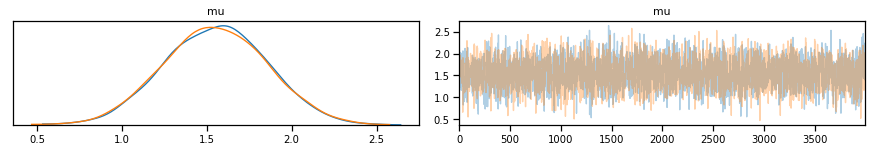

In [8]:
_ = pm.traceplot(trace)

## Comparison to analytical solution
We compute the parameters of the analytical solution below and compare the posterior to that estimated numerically.

In [9]:
# Analytical solution is a normal distribution with the following parameters:
mu_1 = (mu0*tau0 + observed[0]*tau)/(tau0 + tau)
tau_1 = tau0 + tau

mu_1, tau_1

(1.5454545454545454, 11)

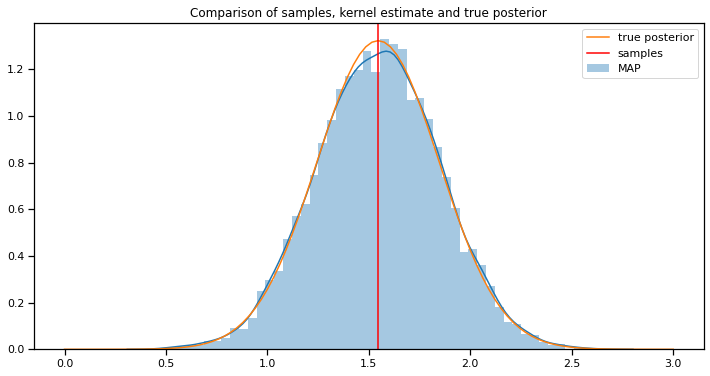

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
sns.distplot(trace['mu'])
z = np.linspace(0, 3, 100)
plt.plot(z, norm.pdf(z, loc=mu_1, scale=tau_1**-0.5))
plt.axvline(model_map['mu'], color='red')
plt.legend(['true posterior', 'samples', 'MAP'])
plt.title('Comparison of samples, kernel estimate and true posterior')
plt.show()

In [10]:
# Let us look at some summary statistics of the posterior distribution
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,1.540189,0.30126,0.008399,0.959992,2.139946


## Conclusion

We have solved the normal likelihood with known precision, normal prior problem analytically and numerically.